# Tutorial 8.3: Learning the Weather-Prediction Task in a Neural Circuit
### Neuroscience goal:
- learn how a single reinforcement signal can lead to changes in specific connections in a manner conducive to the learning of tasks
### Computational goal:
- keep track of connections in different types of connectivity matrix

### Overview
- will produce firing-rate model network comprising five input units (A-E) that provide feedforward input to two units in a decision-making circuit (choices 1, 2)
- will simulate 800 trials
- on each trial, weather is sunny with probablility P(sun), in which case choice 2 is correct (P(2) = P(sun))
    - otherwise, is rainy, so choice 1 is correct with P(1) = 1 - P(sun)
- during a trial the input units receive applied current if the corresponding cue is present; otherwise receive no applied current
- if sunny, the cue corresponding to input units A, B, C, D, E is present with respective probabilities:
    - P(A|2) = 0.95, P(B|2) = 0.75, P(C|2) = 0.5, P(D|2) = 0.25, P(E|2) = 0.05
- if rainy, the cue corresponding to input units A, B, C, D, E is present with respective probabilities:
    - P(A|2) = 0.05, P(B|2) = 0.25, P(C|2) = 0.5, P(D|2) = 0.75, P(E|2) = 0.95

simulate the firing rate of each unit, *i*, as a sigmoid function of its input current, $I_i (t)$, without noise, as:
$
\tau\frac{dr_i}{dt} = -r_i + \frac{r_{max}}{1 + exp[\frac{I_{th} - I_i (t)}{I_\sigma}]}
$

with parameters: tau = 20ms, r_max = 100Hz, i_th = 50, and i_sigma = 5

- each trial should last 500ms with a timestep of dt = 0.001s

input current, $I_i(t)$, for the input units whose corresponding cue is present on a trial should be set as $I_i(t)$ = 50 for t > 0.1s, otherwise 0
- input current to the decision-making units depends on the rates of the input units, through a 5x2 matrix of connections, $W_{ji}^{(In)}$, and the rates of the decision-making units through a 2x2 matrix of connections, $W_{ji}^{(Rec)}$, plus an additional noise term, $I^{rnd}(t)$:
$$
I_i (t) = W^{In}_{Ai}r_A + W^{In}_{Bi}r_B + W^{In}_{Ci}r_C + W^{In}_{Di}r_D + W^{In}_{Ei}r_E + W^{rec}_{1i} + W^{rec}_{2i} + I^{rnd} (t)
$$

initialize all the connections form input units to decision-making units, $W_{ji}^{In}$, to a value of $W_0$ = 0.2
- these will be updated by the plasticity rule
- the decision-making circuit has fixed connections with self-excitation  $W^{rec}_{11} = W^{rec}_{22} = 0.5$, and cross-inhibition  $W^{rec}_{12} = W^{rec}_{21} = -0.5$
- noise current is generated independently for each decision-making unit and independently on each timestep by repeatedly sampling a Gaussian distribution of unit standard deviation and multiplying by a scaling factor of $\sigma_I / \sqrt{\Delta t}$ where $\sigma_I$ = 1
- each separate trial should have independent noise 

use a threshold of 40Hz and determine which of the two decision-making units reaches the rate first (typically only one achieves a high rate) 
    - that unit represents the choice made (1=rain, 2=sun), so add code to determine if the choice is correct, in which case reward is received

synapses between input units and decision units will be updated at the end of each trial according to a three-component rule: 
    - low/high rate of input unit
    - low/high rate of decision-making unit
    - correct/incorrect response

a goal of tutorial is to compare success (in terms of achieving a high rate of correct responses) and stability (in terms of connection strengths remaining within a limited range) of different rules in different conditions
- to achieve this, for each simulation calculate the cumulative number of correct responses and the number of correct in the final 100 trials
- plot synaptic strengths as a function of trial number 
- compare behavior of each rule when connections strengths are unbounded vs bounded such that $0\le W_{ij}\le 2W_0$

for each rule plot the difference in synaptic strength to the two pools as a function of the log likelihood ratio due to a given input unit's activity
- e.g., for input unit A, plot $W_{A2}^{In} - W_{A1}^{In}$ against $\log[(P(A|2))/(P(A|1))]$, where P(A|1) and P(A|2) are the given probabilities, and $W_{A2}^{In} \space\text{and}\space W_{A2}^{In}$ are the connection strengths produced by learning

- in this manner, for each result you will obtain five data points, one for each input unit
- which rule produces the most linear result? a linear result indicates the total difference in input currents to the two decision-making units is proportional to the log-likelihood ratio based on the probability of each unit producing the correct response

### **Rule A**
- assume the reward prediction error, *rpe*, is +0.5 on correct trials and -0.5 on incorrect trials
- update synapses only from input units that were active in the trial (i.e., the corresponding symbol was present)

- update connections from active input units to the active decision-making unit by an amount which is positive on correct trials and negative on incorrect trials:
$$\Delta W_{ij} = +\sigma \text{RPE} $$

and from active input units to the inactive decision-making unit by an amount which is negative on correct trials and positive on incorrect trials:
$$\Delta W_{ij} = -\sigma \text{RPE} $$

where $\sigma = 0.04$ sets the plasticity rate

- treat a trial without a decision as incorrect, so that $\Delta W_{ij}$ is positive from all active inputs to both decision to both decision-making units

### **Rule B**
follow rule A, but calculate the reward prediction error as *rpe* = $R - \langle R \rangle$, where R = 1 if the trial was rewarded, and R = 0  otherwise, while $\langle R \rangle$ is the mean reward across the prior ten trials
- assume $\langle R \rangle$ = 0.5 for the first 10 trials

### **Rule C**
- calculate RPE as in A, but update synapses using soft bounds:
    - $ \Delta W_{ij} = +\sigma\text{RPE}(W_{max} - W_{ij}) $ if RPE > 0 
    - $ \Delta W_{ij} = +\sigma\text{RPE}W_{ij} $ if RPE < 0 
    - $ \Delta W_{ij} = -\sigma\text{RPE}(W_{max} - W_{ij}) $ if RPE < 0
    - $ \Delta W_{ij} = -\sigma\text{RPE}W_{ij} $ if RPE < 0 

### **Rule D**
follow rule B, but only update synapses to active decision-making units from the active input pools

### **Rule E**
follow rule D, but also update to the active decisoin making units from inactive input units by:
- $\Delta W_{ij} = -\sigma\text{RPE}$


In [1342]:
import numpy as np
import matplotlib.pyplot as plt

In [1410]:
# constants
INPUT_UNITS = 5
DECISION_UNITS = 2
SUN_PROBS = np.array([0.95, 0.75, 0.5, 0.25, 0.05])
RAIN_PROBS = np.array([0.05, 0.25, 0.5, 0.75, 0.95])
CHOICE_THRESH = 40 
P_SUN = 0.5
P_RAIN = 1 - P_SUN
RULES = ['a', 'b', 'c', 'd', 'e']

# firing rate parameters
w_0 = 0.2
r_max = 100
i_thresh = 50
i_sigma = 5
sigma_i = 1
tau = 20e-3
tmax = 0.5
dt = 0.001
t = np.arange(0, tmax, dt)
plasticity = 0.04



In [1344]:
def rate(r, i_i):
    drdt = (-r + (r_max / (1 + np.exp((i_thresh - i_i)/i_sigma)))) / tau
    return r + drdt * dt

def generate_cues(probabilities):
    return np.random.rand(5) < probabilities

def get_cues_and_choice():
    """determines weather based on P_SUN and calls generate_cues()"""
    weather = np.random.rand() > P_SUN
    if weather == 1:  # sunny 
        cues = generate_cues(SUN_PROBS)
        choice = 1
    else:             # rainy
        cues = generate_cues(RAIN_PROBS)
        choice = 0
    return cues, choice

def update_decision_current(r_input, r_decision, w_in, w_rec):
    noise = np.random.randn(2) * (sigma_i / np.sqrt(dt))
    return w_in.T @ r_input + w_rec @ r_decision + noise

def get_input_current(cues, t):
    return np.where(cues & (t*dt > 0.1), 50, 0)

In [1402]:
# init functions
def initialize_weights(input_units=INPUT_UNITS, decision_units=DECISION_UNITS):
    w_in = np.full((input_units, decision_units), w_0)  # 5x2 matrix
    w_rec = np.array([[0.5, -0.5], [-0.5, 0.5]])  # 2x2
    return w_in, w_rec

def initialize_rates(units):
    return np.zeros(units)

def initialize_currents(t, input_units=INPUT_UNITS):
    return np.zeros((len(t), input_units))

def initialize_network(rule, input_units=INPUT_UNITS, decision_units=DECISION_UNITS,bound_weights=False):
    # initialize weights
    w_in, w_rec = initialize_weights(input_units, decision_units)

    # initialize rates
    r_input = initialize_rates(input_units)
    r_decision = initialize_rates(decision_units)

    # initialize currents
    i_input = initialize_currents(t)

    # initialize rewards
    rewards = np.zeros(10) + 0.5
    

    params = {'w_in': w_in, 'w_rec': w_rec, 'r_input': r_input, 'r_decision': r_decision, 'i_input': i_input,
              'bound_weights': bound_weights, 'rule': rule, 'reward': rewards}

    return params

### update weights for each rule

In [1445]:
def update_weights(w_in, cues, made_choice, is_correct, rule, rewards=None, sigma=plasticity, bound_weights=False,
                   w_max=2*w_0):
    if rule in ['a', 'c']:
        rpe = 0.5 if is_correct else -0.5
    else:
        rpe = (1 - np.mean(rewards[-10:])) if is_correct else (0 - np.mean(rewards[-10:]))
        rewards = np.append(rewards, rpe)

    for i, cue_present in enumerate(cues):
        if cue_present:
            if made_choice is not None:
                if rule == 'c':
                    delta_w = sigma * rpe
                    if np.sign(delta_w) > 0:
                        # active input units to active decision-making units
                        w_in[i, made_choice] += (sigma * rpe) * (w_max - w_in[i, made_choice])
                        # active input units to inactive decision-making units
                        w_in[i, 1-made_choice] -= (sigma * rpe) * w_in[i, made_choice]
                    else:
                        # active input units to active decision-making units
                        w_in[i, made_choice] -= (sigma * rpe) * (w_max - w_in[i, made_choice])
                        # active input units to inactive decision-making units
                        w_in[i, 1-made_choice] += (sigma * rpe) * w_in[i, made_choice]
                else:
                    w_in[i, made_choice] += sigma * rpe
                    if rule in ['a', 'b']:
                        w_in[i, 1-made_choice] -= sigma * rpe
            else:
                w_in[i, :] += sigma * rpe
                if rule == 'e' and not cue_present:
                    w_in[i, made_choice] -= sigma * rpe

    if bound_weights:
        w_in = np.clip(w_in, 0, w_max)
    
    return w_in, rewards

In [1429]:
def plot_synaptic_strengths(weights_over_time, ax):
    
    
    for i in range(weights_over_time[0].shape[0]):
        for j in range(weights_over_time[0].shape[1]):
            if j == 1:
                ax.plot([weights[i, j] for weights in weights_over_time], label=f'w_{i}{j}', linestyle='--')
            else:
                ax.plot([weights[i, j] for weights in weights_over_time], label=f'w_{i}{j}', linestyle='-')

    ax.legend(loc='upper right')
    ax.set_xlabel('trial number')
    ax.set_ylabel('synaptic strength')

    return ax

In [1419]:
def run_trial(network_params):
    w_in = network_params['w_in']
    w_rec = network_params['w_rec']
    r_input = network_params['r_input']
    r_decision = network_params['r_decision']
    i_input = network_params['i_input']
    bound_weights = network_params['bound_weights']
    rule = network_params['rule']
    rewards = network_params['reward']

    # get cues
    cues, correct_choice = get_cues_and_choice()
    
    # store decision-layer rates
    r_decision_over_time = np.zeros((len(t), 2))
    r_input_over_time = np.zeros((len(t), 5))

    # decision variables
    decision_made = False
    made_choice = None
    is_correct = False
    threshold_rate = CHOICE_THRESH
    

    # loop through t
    for i in range(1, len(t)):
        # current to input layer
        i_input = get_input_current(cues, i)

        # update input layer firing rates
        r_input = rate(r_input, i_input)
        r_input_over_time[i, :] = r_input
        # update decision layer current, firing rate
        i_decision = update_decision_current(r_input, r_decision, w_in, w_rec)
        r_decision = rate(r_decision, i_decision)

        # store decision unit firing rate
        r_decision_over_time[i, :] = r_decision       

        # determine choice
        if not decision_made and np.any(r_decision >= threshold_rate):
            made_choice = np.argmax(r_decision)
            decision_made = True
            is_correct = made_choice == correct_choice
            break
            

    # reward-prediction error
    # rpe = rpe_correct if is_correct else rpe_incorrect

    # update weights
    w_in, rewards = update_weights(w_in, cues, made_choice, is_correct, rule, rewards,
                                              bound_weights=bound_weights)


    trial_result = {
        'cues': cues,
        'made_choice': made_choice,
        'is_correct': is_correct,
        'w_in': w_in,
        'r_decision_over_time': r_decision_over_time,
        'correct_choice': correct_choice,
        'reward': rewards
    }

    return trial_result
    
def run_trials(num_trials=800, rule='a', bound_weights=False, plot=False):
    is_correct = np.zeros(num_trials)

    # store weights
    weights_over_time = []
    # store rewards
    rewards = np.zeros(num_trials)
    rewards[:10] = 0.5

    params=initialize_network(rule=rule, bound_weights=bound_weights)
    params['reward'] = rewards

    for trial in range(num_trials):
        # run trial
        result = run_trial(params)
        # append array
        is_correct[trial] = result['is_correct']
        params['w_in'] = result['w_in']
        params['reward'] = result['reward']
        
        weights_over_time.append(params['w_in'].copy())
    
    # Plot synaptic strengths after all trials are complete
    if plot:
        plot_synaptic_strengths(weights_over_time)


    return is_correct, weights_over_time

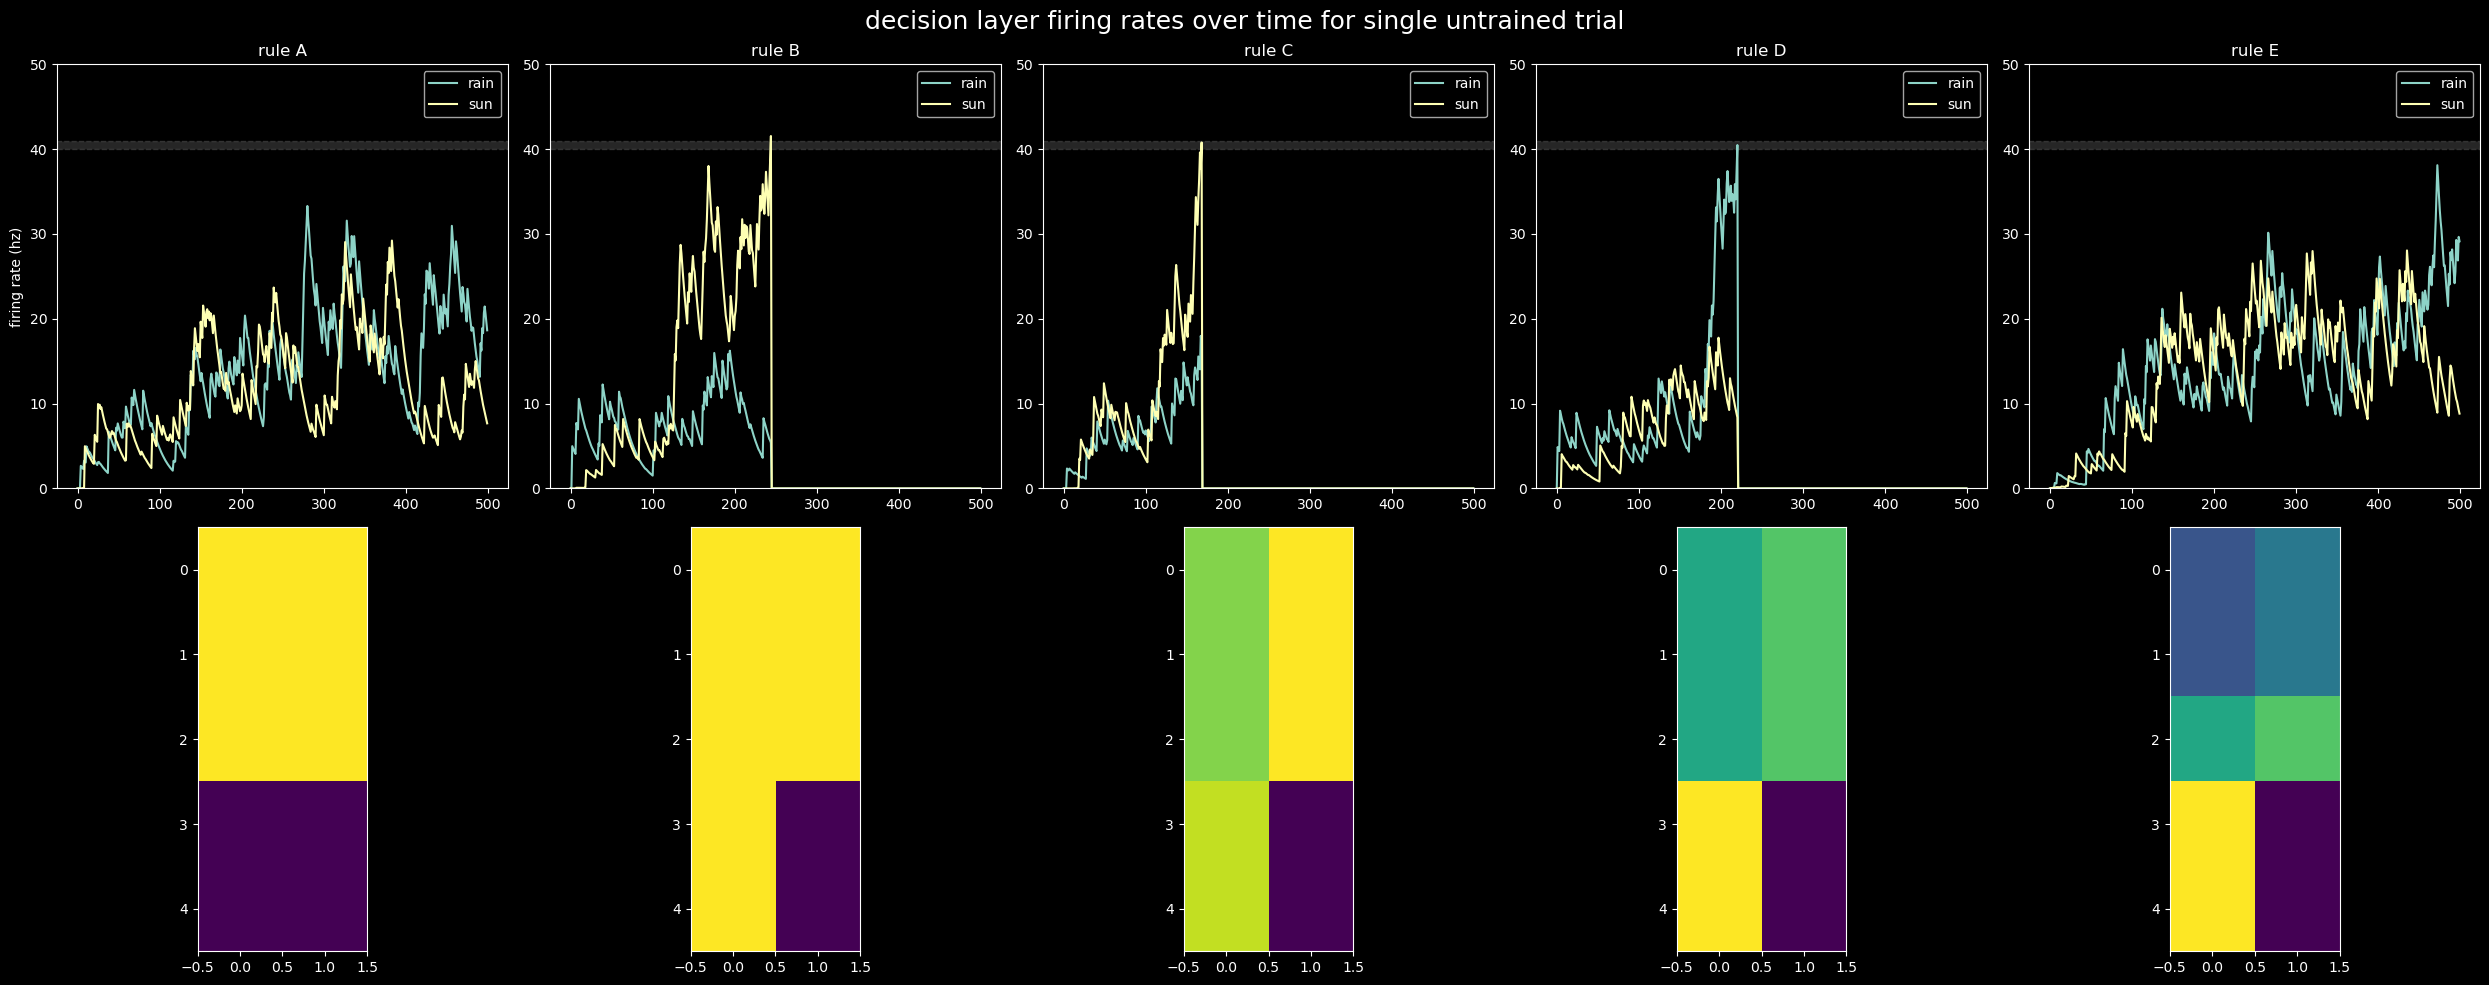

In [1447]:
fig, ax = plt.subplots(2, 5, figsize=(25,10))

unbound_params = initialize_network(rule='a', bound_weights=False)

for i, rule in enumerate(RULES):
    unbound_params['rule'] = rule
    result = run_trial(unbound_params)

    ax[0][i].plot(result['r_decision_over_time'][:, 0], label='rain')
    ax[0][i].plot(result['r_decision_over_time'][:, 1], label='sun')
    ax[0][i].set_ylim(0, 50)
    ax[0][i].axhspan(40, 41, linestyle='--', alpha=0.3, color='gray')
    ax[0][i].legend()
    ax[0][i].set_title(f'rule {rule.upper()}')

    ax[1][i].imshow(result['w_in'])

ax[0][0].set_ylabel('firing rate (hz)')
fig.suptitle('decision layer firing rates over time for single untrained trial', fontsize=18)
plt.tight_layout()
plt.show()

### all rules, bound and unbound

Text(0, 0.5, 'number of trials')

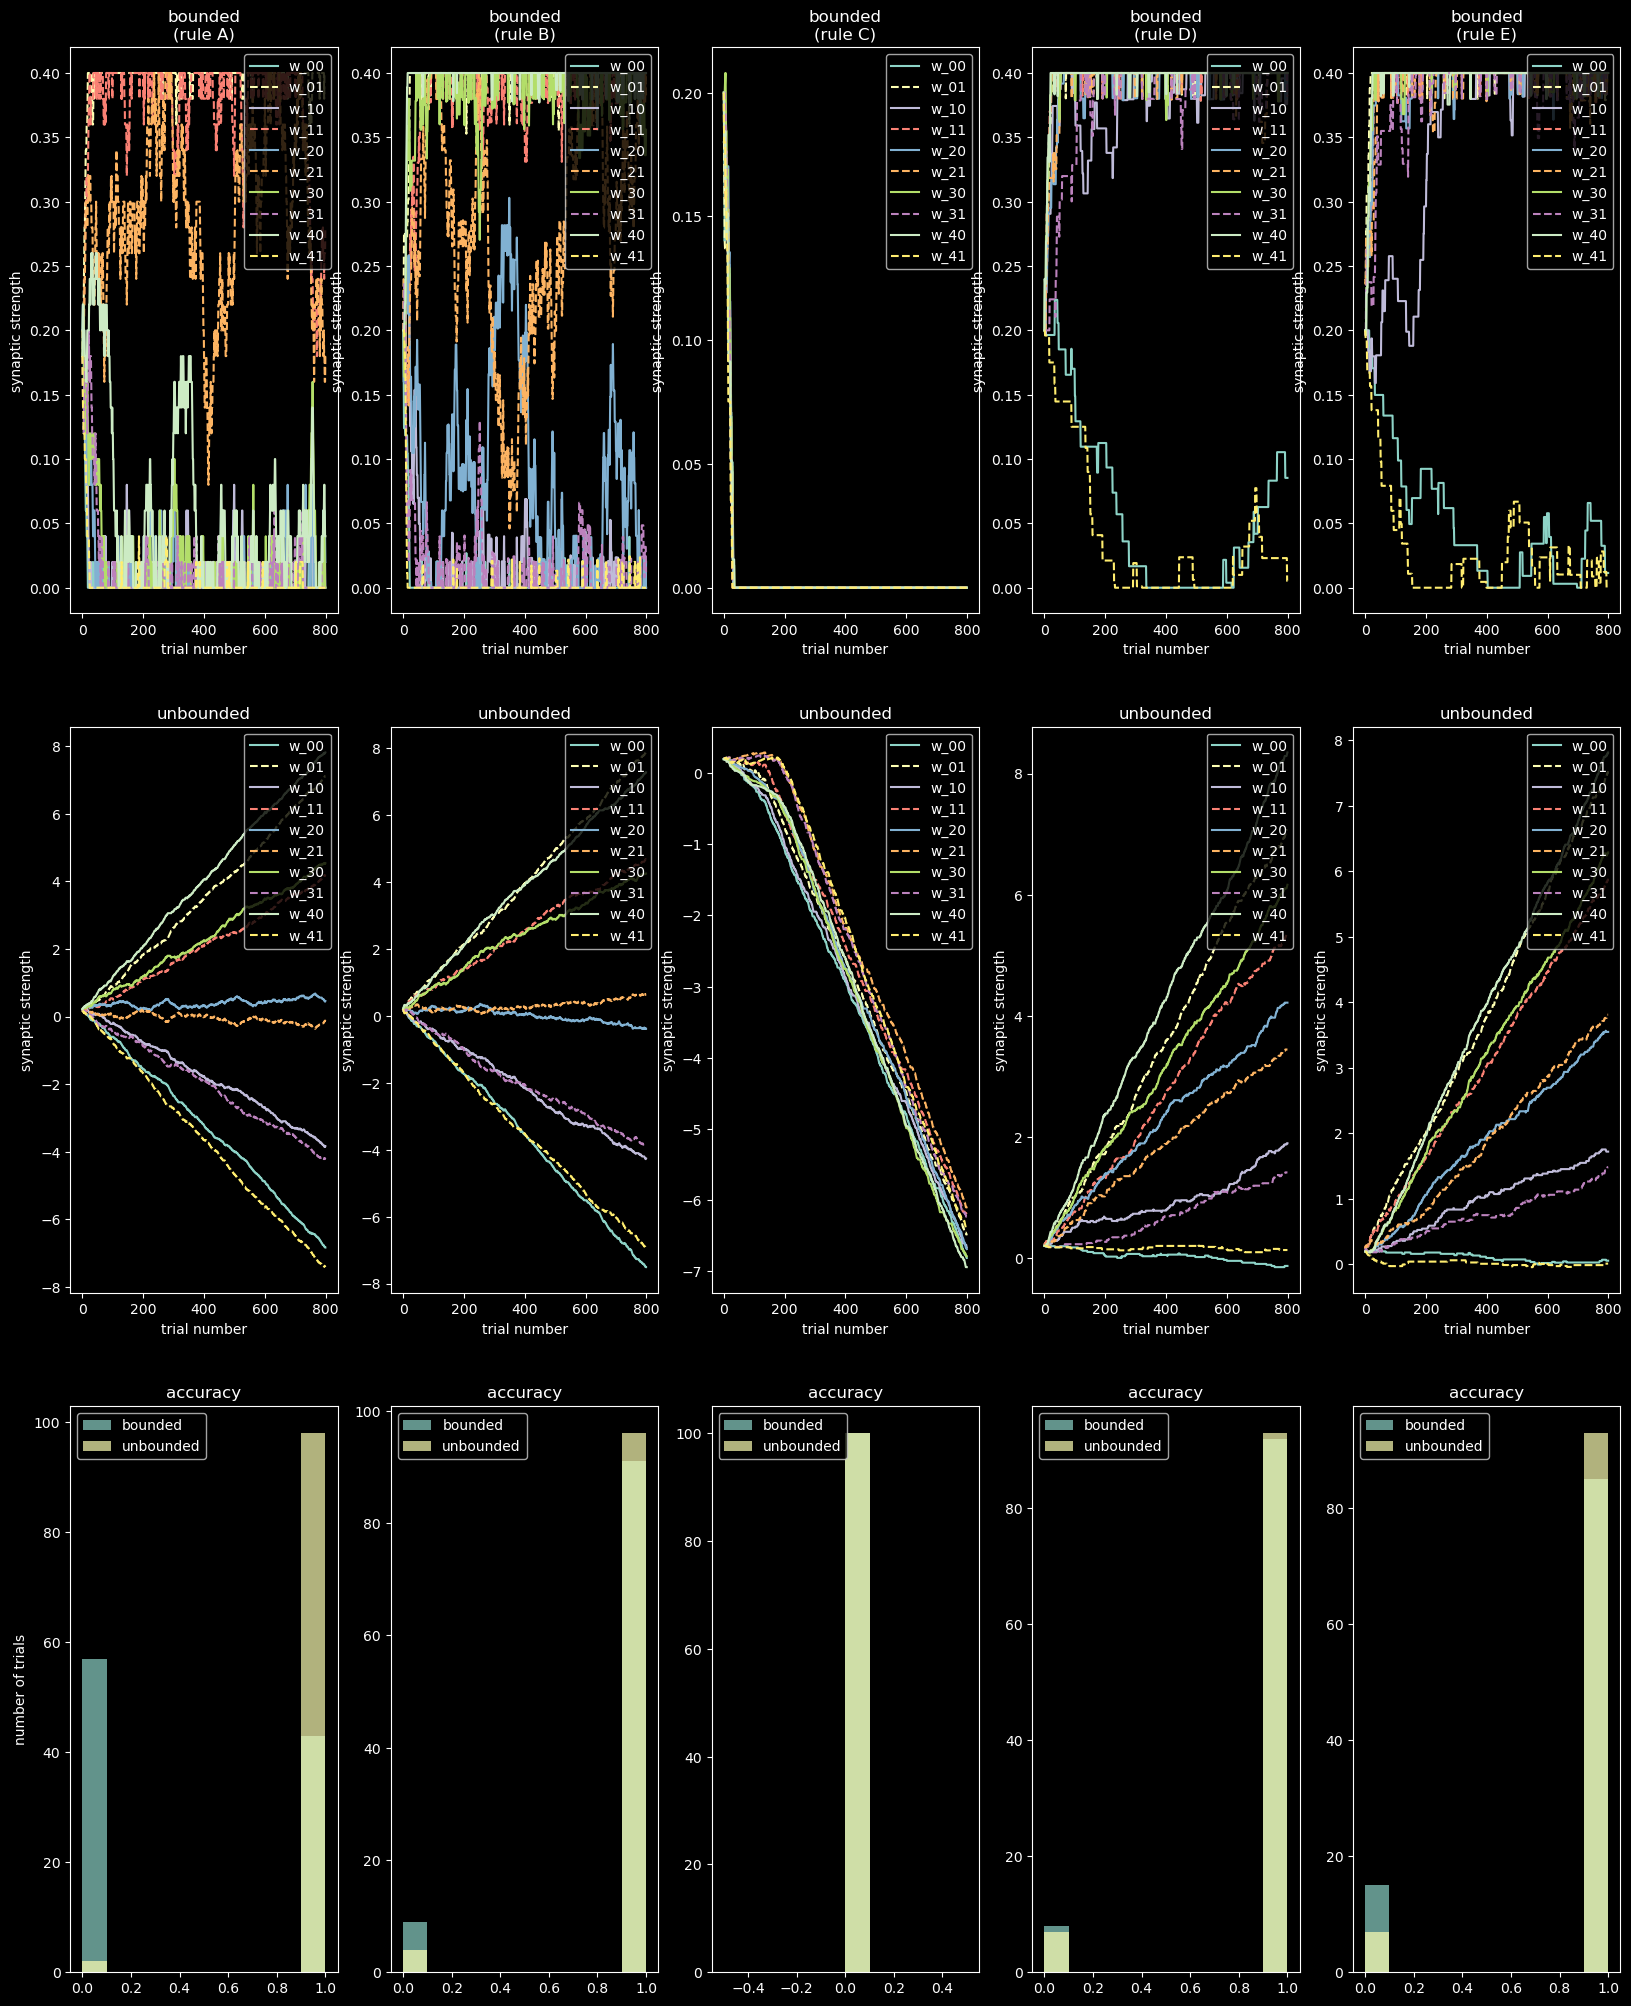

In [1448]:
fig, ax = plt.subplots(3, 5, figsize=(20, 25))

for i, rule in enumerate(RULES):
    bounded, weights_bounded = run_trials(rule=rule, bound_weights=True)
    unbounded, weights_unbounded = run_trials(rule=rule, bound_weights=False)

    ax[0][i] = plot_synaptic_strengths(weights_bounded, ax[0][i])
    ax[0][i].set_title(f'bounded\n(rule {rule.upper()})')

    ax[1][i] = plot_synaptic_strengths(weights_unbounded, ax[1][i])
    ax[1][i].set_title('unbounded')

    ax[2][i].hist(bounded[-100:], label='bounded', alpha=0.7)
    ax[2][i].hist(unbounded[-100:], label='unbounded', alpha=0.7)
    ax[2][i].set_title('accuracy')
    ax[2][i].legend(loc='upper left')

ax[0][0].set_ylabel('synaptic strength')
ax[1][0].set_ylabel('synaptic strength')
ax[2][0].set_ylabel('number of trials')


In [1437]:
def compute_log_likelihood(p2, p1):
    return np.log(p2/p1)

def get_log_likelihood():
    log_likelihoods = []
    for i in range(5):
        a2 = SUN_PROBS[i]
        a1 = 1 - a2
        log_likelihoods.append(compute_log_likelihood(a2, a1))
    return np.asarray(log_likelihoods)

def plot_difference_vs_log_likelihood(final_weights, rule_name, plot=True):
    differences = get_differences(final_weights)
    log_likelihoods = get_log_likelihood()

    if plot:
        plt.scatter(log_likelihoods, differences)
        plt.xlabel('log likelihood')
        plt.ylabel('difference in synaptic strength')
        plt.title('difference in synaptic strength vs log likelihood ratio')
        plt.grid(which='both', alpha=0.3)
        plt.suptitle(rule_name)
        plt.show()

    return differences

def get_differences(final_weights):
    return [final_weights[i][1] - final_weights[i][0] for i in range(len(final_weights))]
    

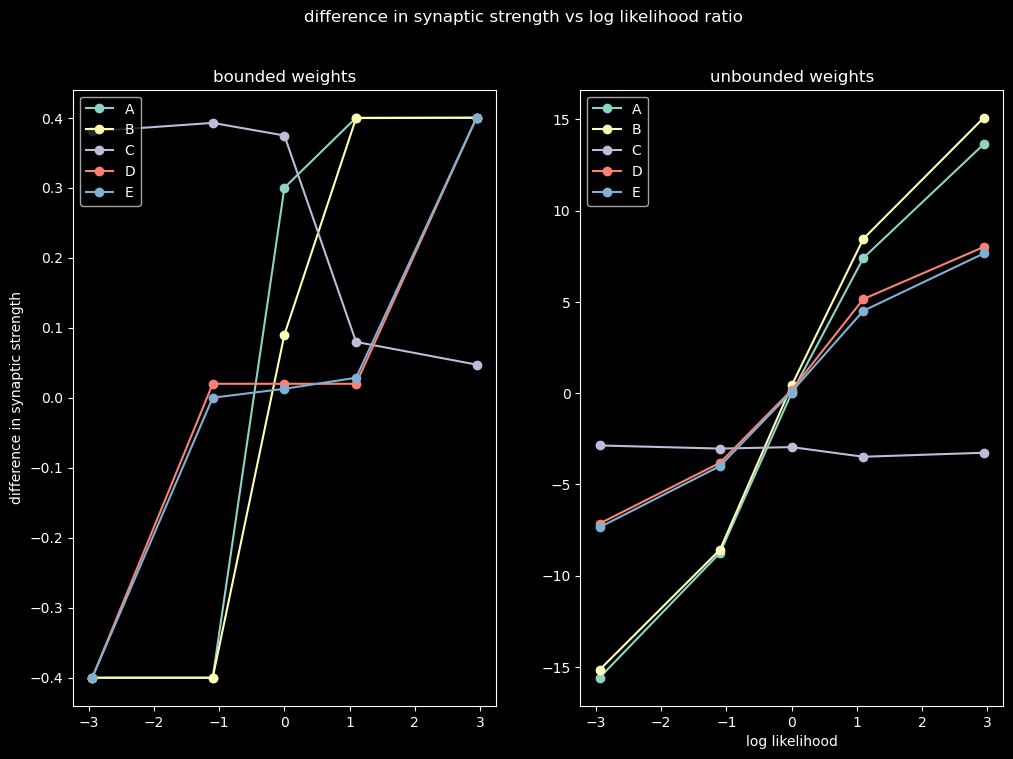

In [1449]:
fig, ax = plt.subplots(1, 2, figsize=(12, 8))
log_likelihoods = get_log_likelihood()

for i, rule in enumerate(RULES):
    bounded, weights_bounded = run_trials(rule=rule, bound_weights=True)
    unbounded, weights_unbounded = run_trials(rule=rule, bound_weights=False)
    bounded_differences = get_differences(weights_bounded[-1])
    unbounded_differences = get_differences(weights_unbounded[-1])

    ax[0].plot(log_likelihoods, bounded_differences, label=f'{rule.upper()}', marker='o')
    ax[1].plot(log_likelihoods, unbounded_differences, label=f'{rule.upper()}', marker='o')

fig.suptitle('difference in synaptic strength vs log likelihood ratio')
ax[0].set_title('bounded weights')
ax[0].set_ylabel('difference in synaptic strength')
ax[1].set_title('unbounded weights')
ax[1].set_xlabel('log likelihood')
ax[0].legend(loc='upper left')
ax[1].legend(loc='upper left')


# alternative training protocols

### 1.
- change p(sun) to 0.2
- how do final connection strengths and performance change?

In [1450]:
P_SUN = 0.2
P_RAIN = 1 - P_SUN

Text(0, 0.5, 'number of trials')

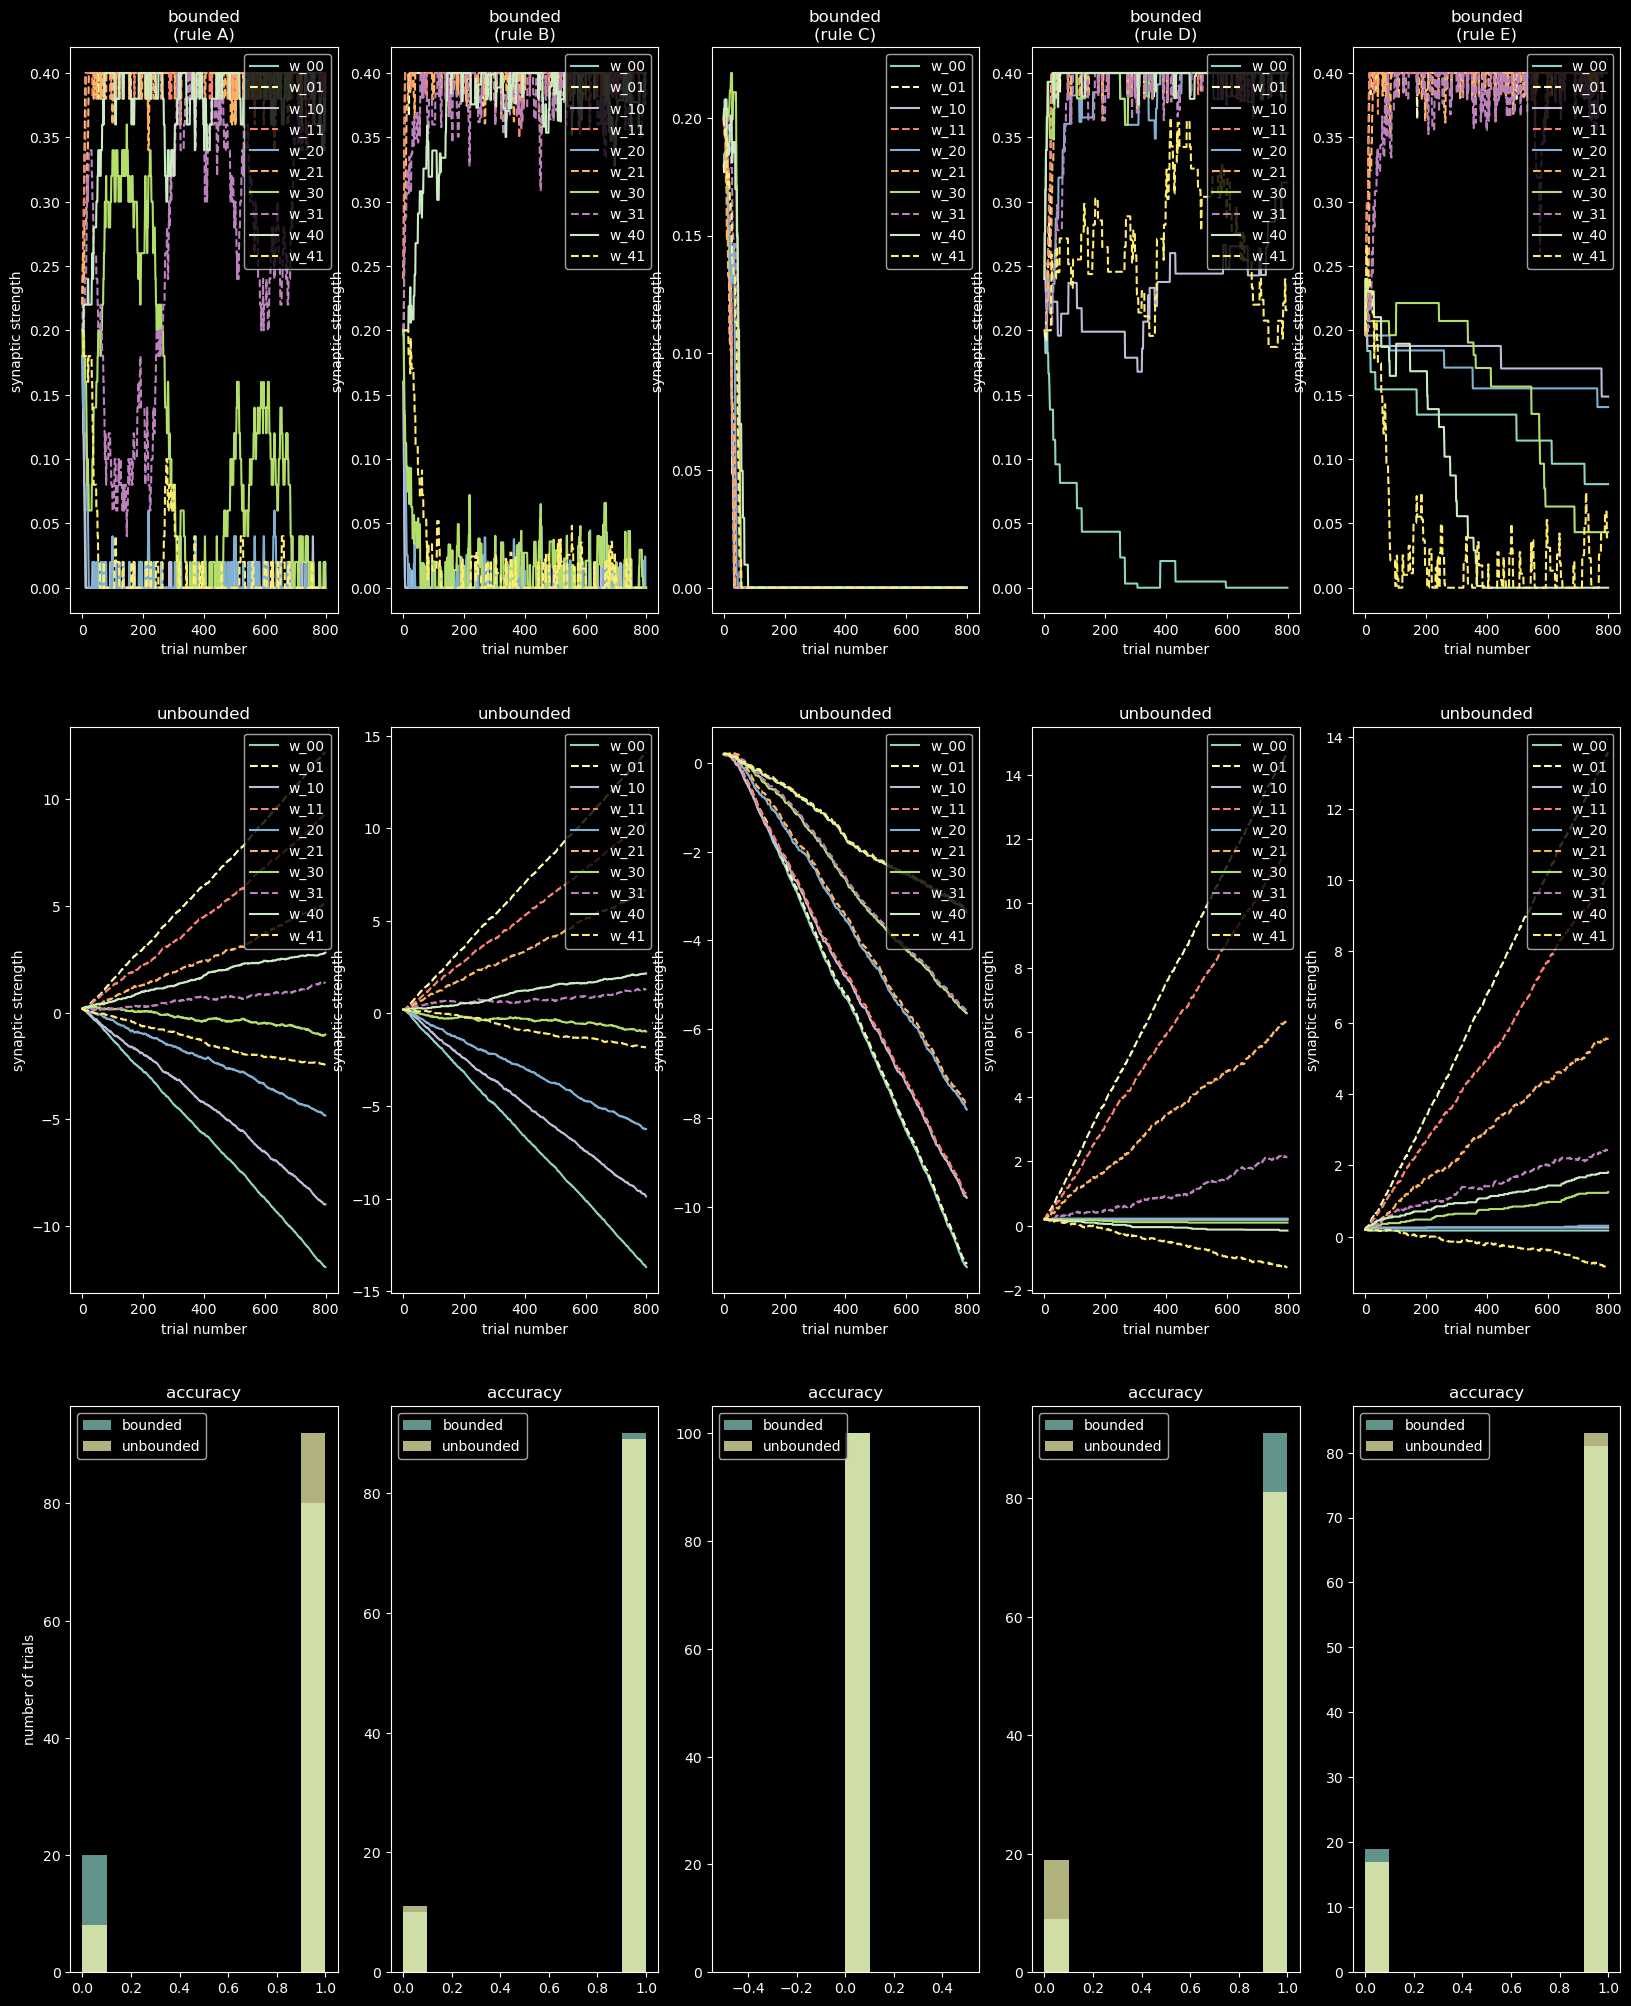

In [1451]:
fig, ax = plt.subplots(3, 5, figsize=(20, 25))

for i, rule in enumerate(RULES):
    bounded, weights_bounded = run_trials(rule=rule, bound_weights=True)
    unbounded, weights_unbounded = run_trials(rule=rule, bound_weights=False)

    ax[0][i] = plot_synaptic_strengths(weights_bounded, ax[0][i])
    ax[0][i].set_title(f'bounded\n(rule {rule.upper()})')

    ax[1][i] = plot_synaptic_strengths(weights_unbounded, ax[1][i])
    ax[1][i].set_title('unbounded')

    ax[2][i].hist(bounded[-100:], label='bounded', alpha=0.7)
    ax[2][i].hist(unbounded[-100:], label='unbounded', alpha=0.7)
    ax[2][i].set_title('accuracy')
    ax[2][i].legend(loc='upper left')

ax[0][0].set_ylabel('synaptic strength')
ax[1][0].set_ylabel('synaptic strength')
ax[2][0].set_ylabel('number of trials')


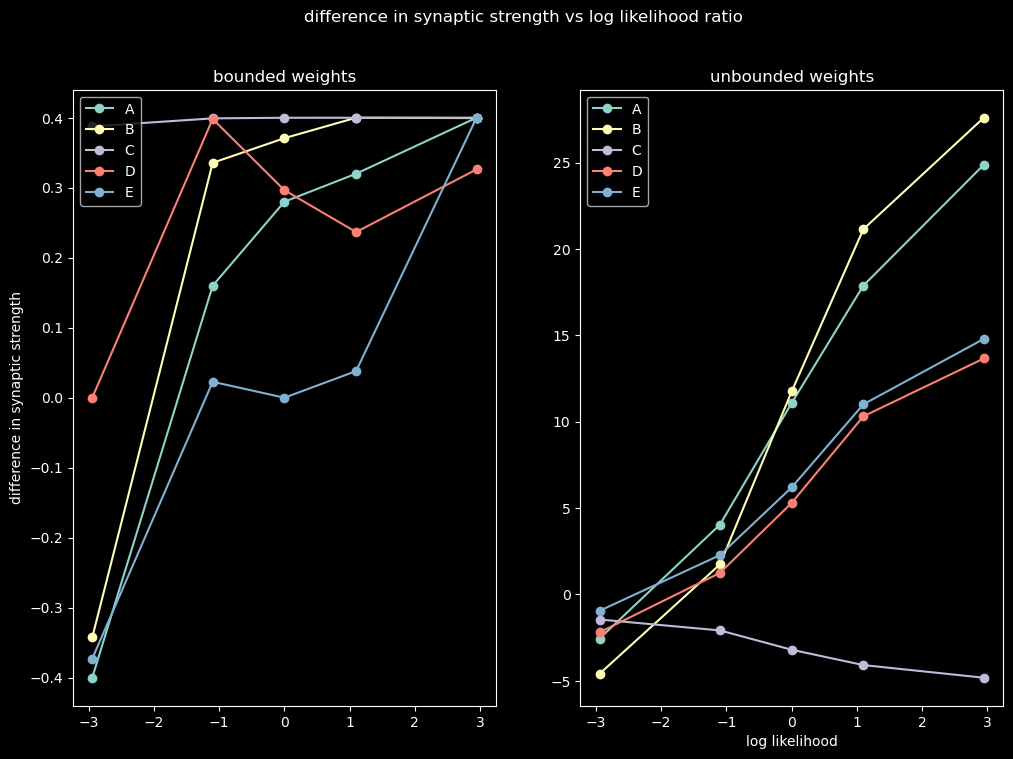

In [1452]:
fig, ax = plt.subplots(1, 2, figsize=(12, 8))
log_likelihoods = get_log_likelihood()

for i, rule in enumerate(RULES):
    bounded, weights_bounded = run_trials(rule=rule, bound_weights=True)
    unbounded, weights_unbounded = run_trials(rule=rule, bound_weights=False)
    bounded_differences = get_differences(weights_bounded[-1])
    unbounded_differences = get_differences(weights_unbounded[-1])

    ax[0].plot(log_likelihoods, bounded_differences, label=f'{rule.upper()}', marker='o')
    ax[1].plot(log_likelihoods, unbounded_differences, label=f'{rule.upper()}', marker='o')

fig.suptitle('difference in synaptic strength vs log likelihood ratio')
ax[0].set_title('bounded weights')
ax[0].set_ylabel('difference in synaptic strength')
ax[1].set_title('unbounded weights')
ax[1].set_xlabel('log likelihood')
ax[0].legend(loc='upper left')
ax[1].legend(loc='upper left')


### 2. 
- increase number of trials to 4,000
- for which plasticity rules do the connection strengths reach a steady state?

C:\Users\paul.olsen\AppData\Local\Temp\ipykernel_7204\534139632.py:2: RuntimeWarning: overflow encountered in exp
  drdt = (-r + (r_max / (1 + np.exp((i_thresh - i_i)/i_sigma)))) / tau


Text(0, 0.5, 'number of trials')

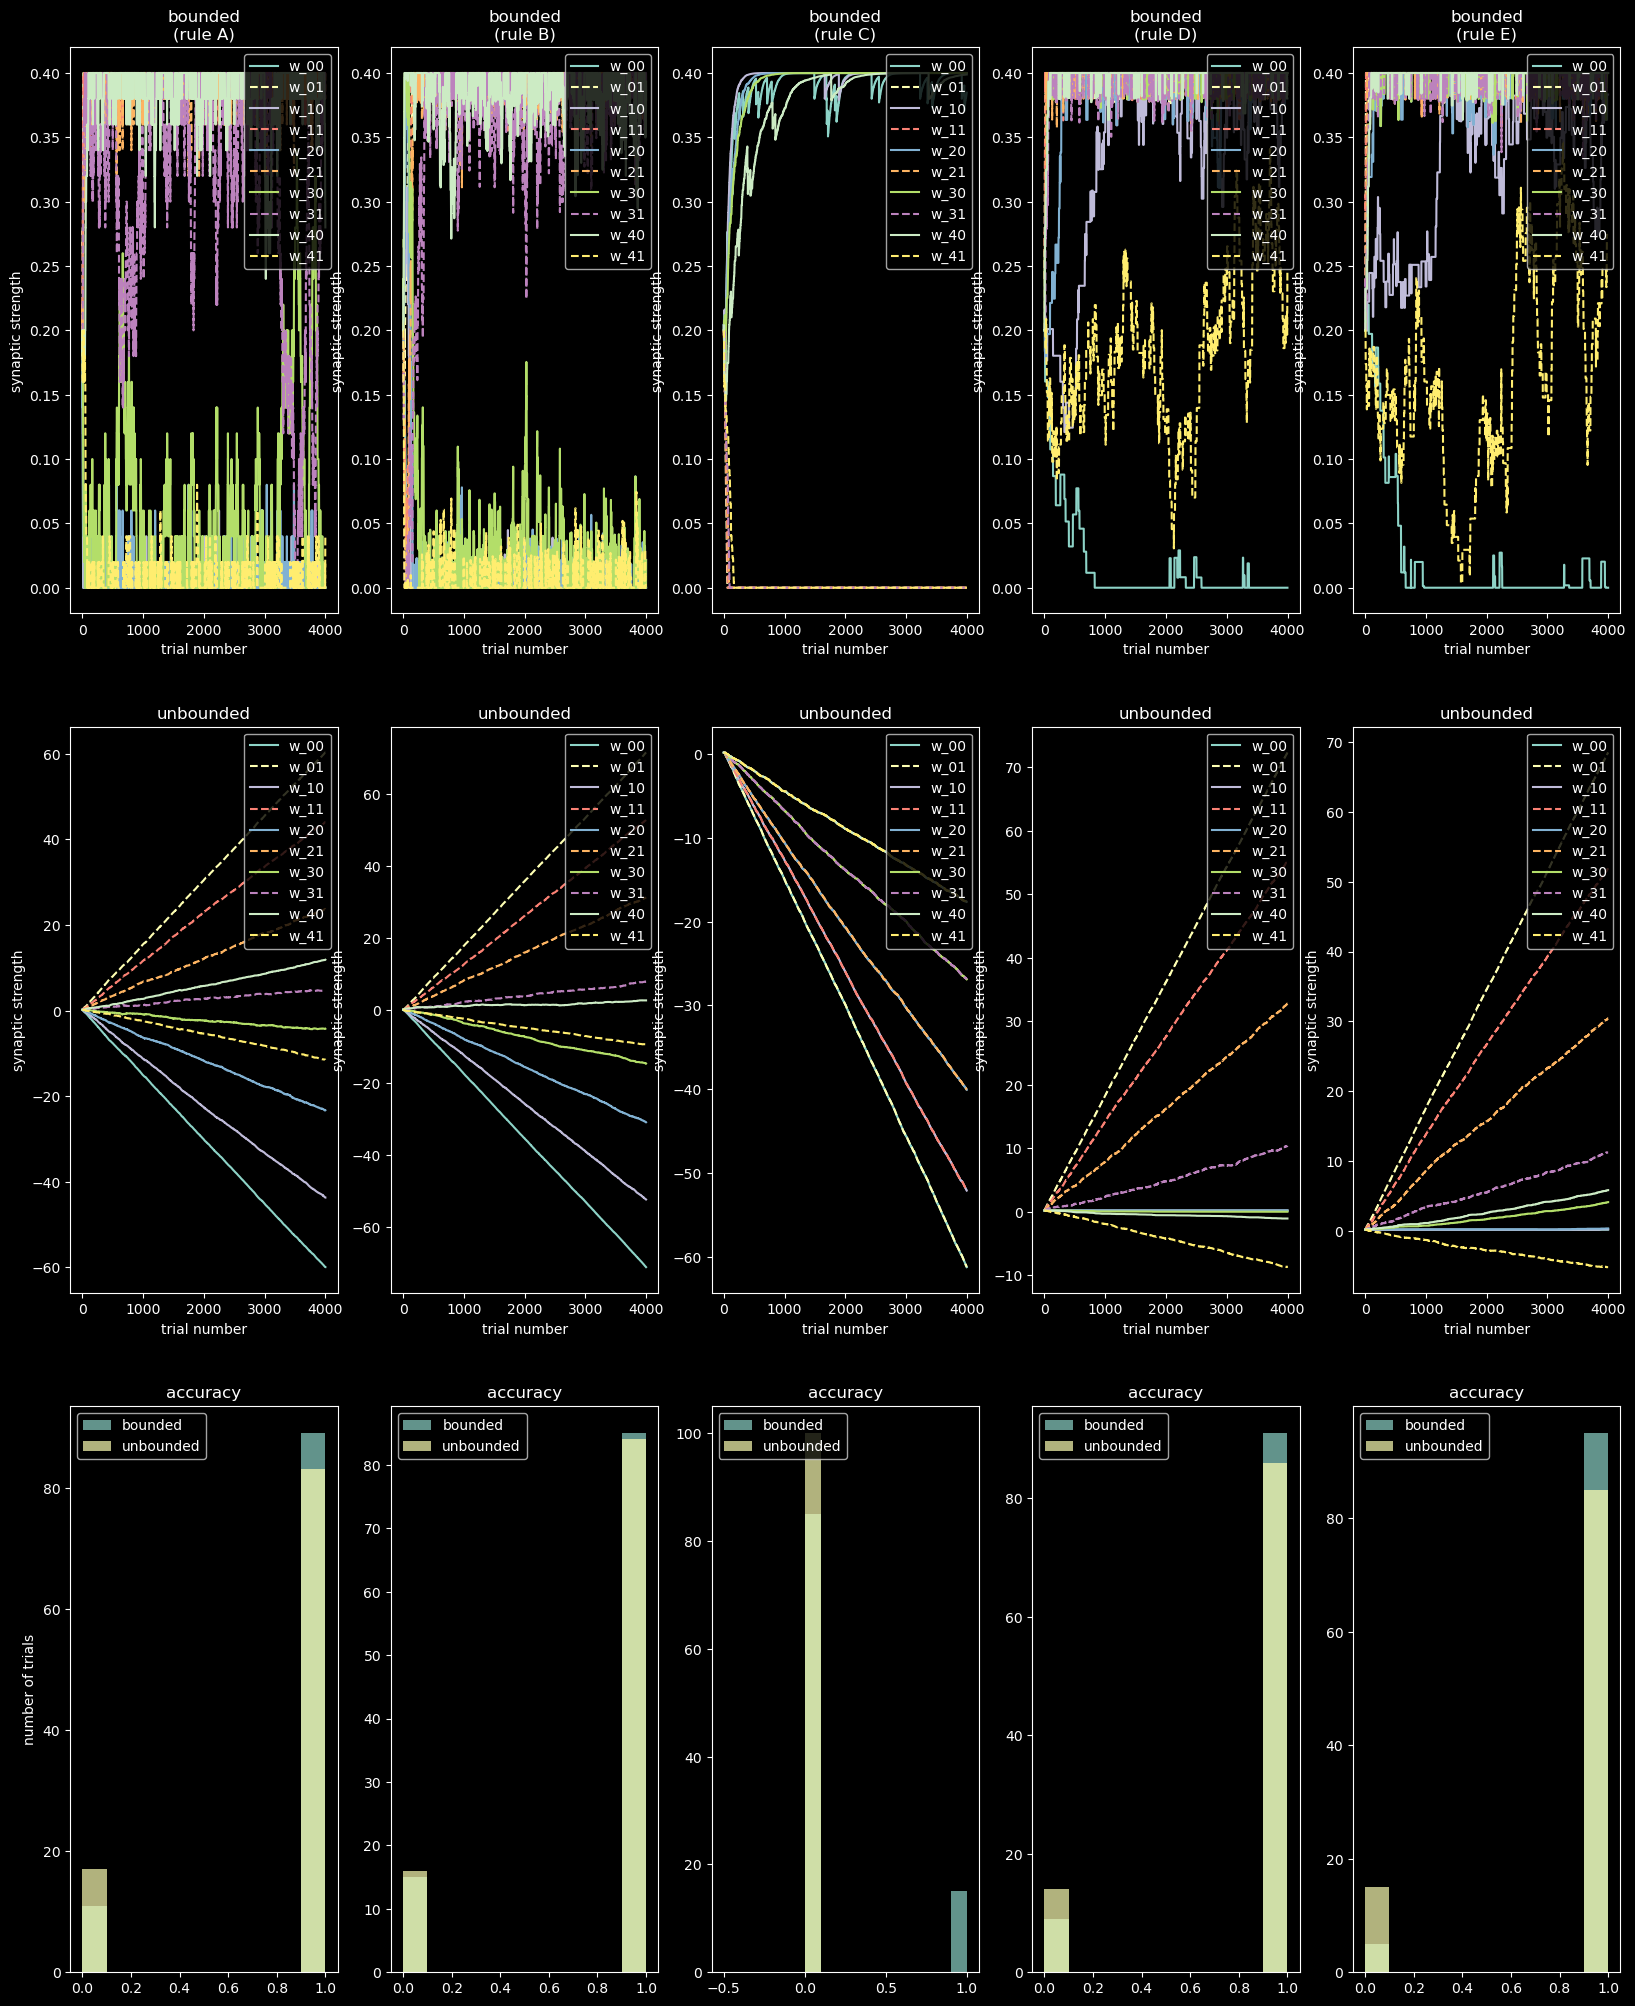

In [1453]:
fig, ax = plt.subplots(3, 5, figsize=(20, 25))

for i, rule in enumerate(RULES):
    bounded, weights_bounded = run_trials(num_trials=4000, rule=rule, bound_weights=True)
    unbounded, weights_unbounded = run_trials(num_trials=4000, rule=rule, bound_weights=False)

    ax[0][i] = plot_synaptic_strengths(weights_bounded, ax[0][i])
    ax[0][i].set_title(f'bounded\n(rule {rule.upper()})')

    ax[1][i] = plot_synaptic_strengths(weights_unbounded, ax[1][i])
    ax[1][i].set_title('unbounded')

    ax[2][i].hist(bounded[-100:], label='bounded', alpha=0.7)
    ax[2][i].hist(unbounded[-100:], label='unbounded', alpha=0.7)
    ax[2][i].set_title('accuracy')
    ax[2][i].legend(loc='upper left')

ax[0][0].set_ylabel('synaptic strength')
ax[1][0].set_ylabel('synaptic strength')
ax[2][0].set_ylabel('number of trials')


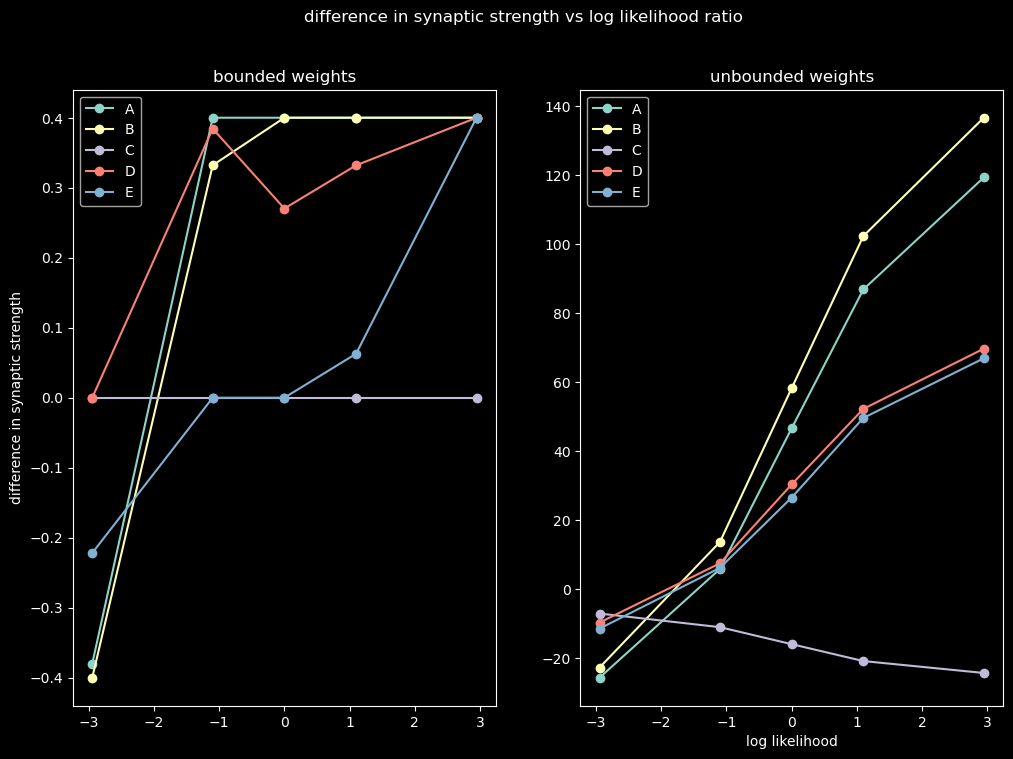

In [1454]:
fig, ax = plt.subplots(1, 2, figsize=(12, 8))
log_likelihoods = get_log_likelihood()

for i, rule in enumerate(RULES):
    bounded, weights_bounded = run_trials(num_trials=4000, rule=rule, bound_weights=True)
    unbounded, weights_unbounded = run_trials(num_trials=4000, rule=rule, bound_weights=False)
    bounded_differences = get_differences(weights_bounded[-1])
    unbounded_differences = get_differences(weights_unbounded[-1])

    ax[0].plot(log_likelihoods, bounded_differences, label=f'{rule.upper()}', marker='o')
    ax[1].plot(log_likelihoods, unbounded_differences, label=f'{rule.upper()}', marker='o')

fig.suptitle('difference in synaptic strength vs log likelihood ratio')
ax[0].set_title('bounded weights')
ax[0].set_ylabel('difference in synaptic strength')
ax[1].set_title('unbounded weights')
ax[1].set_xlabel('log likelihood')
ax[0].legend(loc='upper left')
ax[1].legend(loc='upper left')
